## Data set segmentation

In [1]:
import os
import random
import shutil

# 定义路径
dataset_path = 'Nepali_vehicle_dataset'
output_path = 'yolov5/data'
categories = ['ambulance', 'auto_rickshaw', 'bikes', 'bus', 'car', 'e-rickshaw', 
              'micro_bus', 'mini_truck', 'police_vehicle', 'school_bus', 'scooter', 
              'SUV', 'taxi', 'tempo', 'tractor', 'transport_vehicle', 'truck', 'van']

# 创建或清空输出目录
for folder in ['images/train', 'images/val', 'images/test', 'labels/train', 'labels/val', 'labels/test']:
    path = os.path.join(output_path, folder)
    if os.path.exists(path):
        shutil.rmtree(path)  # 删除旧的目录
    os.makedirs(path)        # 创建新的空目录

# 遍历每个类别并分割数据集
for category in categories:
    image_dir = os.path.join(dataset_path, category, 'images')
    label_dir = os.path.join(dataset_path, category, 'labels')
    
    files = os.listdir(image_dir)
    random.shuffle(files)

    train_split = int(len(files) * 0.8)  # 80% for training
    val_split = int(len(files) * 0.9)    # 90% for training + validation (10% for validation)

    for i, file in enumerate(files):
        img_file = os.path.join(image_dir, file)
        label_file = os.path.join(label_dir, os.path.splitext(file)[0] + '.txt')

        if i < train_split:
            target_folder = 'train'
        elif i < val_split:
            target_folder = 'val'
        else:
            target_folder = 'test'

        target_img_path = os.path.join(output_path, 'images', target_folder, file)
        target_label_path = os.path.join(output_path, 'labels', target_folder, os.path.splitext(file)[0] + '.txt')

        # 只有当目标文件不存在时才复制
        if not os.path.exists(target_img_path):
            shutil.copy(img_file, target_img_path)
        if not os.path.exists(target_label_path):
            shutil.copy(label_file, target_label_path)

print("Dataset splitting completed.")

Dataset splitting completed.


## Create a profile (data.yaml)

In [2]:
# 创建 data.yaml 文件内容
yaml_content = """train: ../data/images/train
val: ../data/images/val
test: ../data/images/test  # 添加测试集路径

nc: 18  # 类别数量
names: ['ambulance', 'auto_rickshaw', 'bikes', 'bus', 'car', 'e-rickshaw', 'micro_bus', 'mini_truck', 'police_vehicle', 'school_bus', 'scooter', 'SUV', 'taxi', 'tempo', 'tractor', 'transport_vehicle', 'truck', 'van']
"""

# 写入 data.yaml 文件
with open('yolov5/data/data.yaml', 'w') as file:
    file.write(yaml_content)

print("Configuration file created.")

Configuration file created.


In [3]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))

PyTorch version: 2.5.1+cu118
CUDA available: True
CUDA version: 11.8
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 4070 Laptop GPU


## Train the model

In [4]:
import os
import subprocess
import shutil
from IPython.display import clear_output, display
import ipywidgets as widgets

# 创建两个 Output 小部件
output1 = widgets.Output()
output2 = widgets.Output()

# 显示这两个小部件
display(output1, output2)

# 设置环境变量以忽略 GitPython 初始化失败的问题
os.environ['GIT_PYTHON_REFRESH'] = 'quiet'

# 定义训练命令
train_command = [
    "python", "train.py",
    "--img", "640",
    "--batch", "16",
    "--epochs", "10",  # 确保这里设置的轮数与您期望的一致
    "--data", "data/data.yaml", 
    "--weights", "yolov5s.pt",
    "--device", "0",  # 添加丢失的逗号
    "--project", "runs/train",  # 指定项目目录
    "--name", "exp"             # 指定实验名称，这将确保输出总是放在 train/exp 中
]

# 定义要清理的路径
output_dir = os.path.join("yolov5", "runs", "train", "exp")

def decide_output(line):
    """Decide which output widget the line should be sent to."""
    complete_progress_keyword = '100%'  # 或者其他表示进度条完成的关键字
    progress_keywords = ['Epoch', 'ETA', 'it/s', 's/it']
    warning_keywords = ['Warning', 'with torch.cuda.amp.autocast']
    epoch_header_keywords = ['Epoch', 'GPU_mem', 'box_loss', 'obj_loss', 'cls_loss', 'Instances', 'Size']
    
    if complete_progress_keyword in line:
        return output1
    elif all(keyword in line for keyword in epoch_header_keywords[:6]):  # 检查 Epoch 标题行
        return output1
    elif any(keyword in line for keyword in progress_keywords + warning_keywords):
        return output2
    else:
        return output1

try:
    # 如果 exp 文件夹存在，则删除它
    if os.path.exists(output_dir):
        with output1:
            print(f"Deleted existing directory: {output_dir}")
        shutil.rmtree(output_dir)

    with subprocess.Popen(
            train_command,
            cwd="yolov5",  # 确保这是 YOLOv5 项目的根目录
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,  # 合并标准输出和标准错误
            text=True,                 # 使用文本模式
            encoding='utf-8',          # 明确指定编码为 utf-8
            errors='replace'           # 无法解码的字符将被替换
    ) as process:
        last_progress_line = ""
        for line in process.stdout:
            target_output = decide_output(line)
            
            if target_output == output2:
                with target_output:
                    clear_output(wait=True)
                    print(last_progress_line, end='')  # 保留之前的进度条
                    print(line, end='')  # 输出当前的进度条或提示信息
                    last_progress_line = line
            elif not line.isspace() and line:
                with target_output:
                    print(line, end='')

    # 检查返回码以确认是否成功完成
    if process.returncode != 0:
        with output1:
            print(f"\nTraining failed with return code {process.returncode}")
    else:
        with output1:
            print("\nModel training completed.")
        # 清空 output2 的输出
        with output2:
            output2.clear_output()

except Exception as e:
    with output1:
        print(f"\nAn error occurred: {e}")

Output()

Output()

## Evaluate model performance

Model evaluation completed.
Final Results:



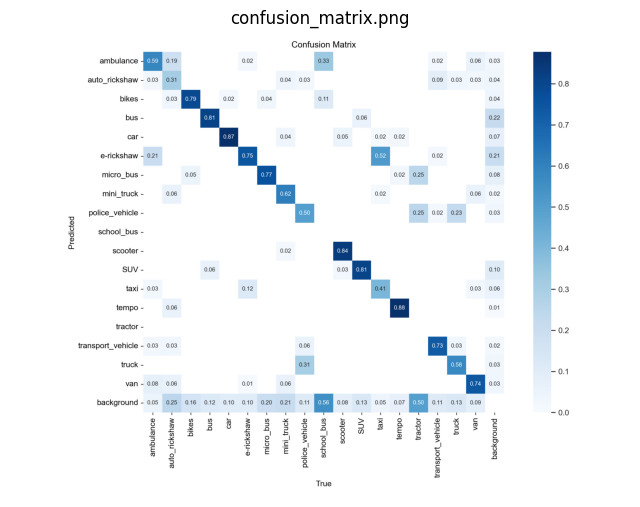

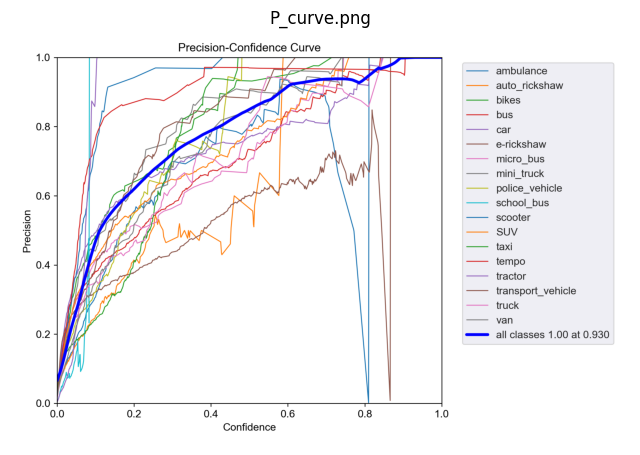

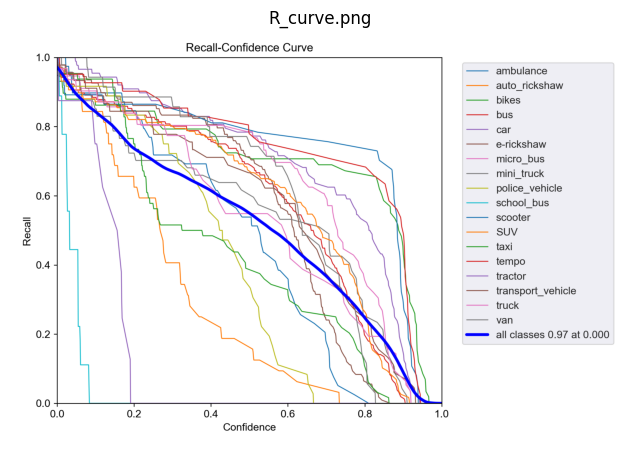

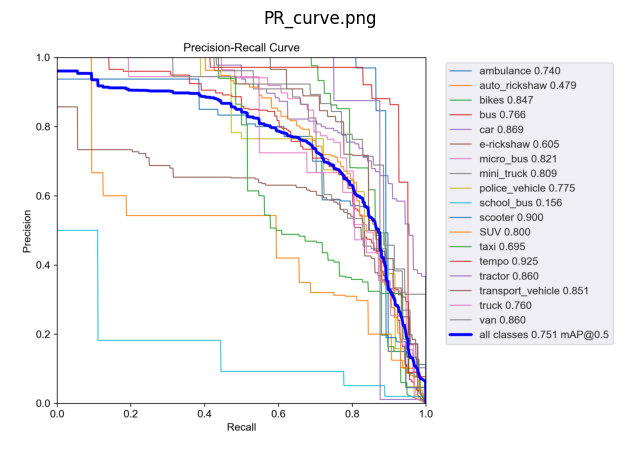

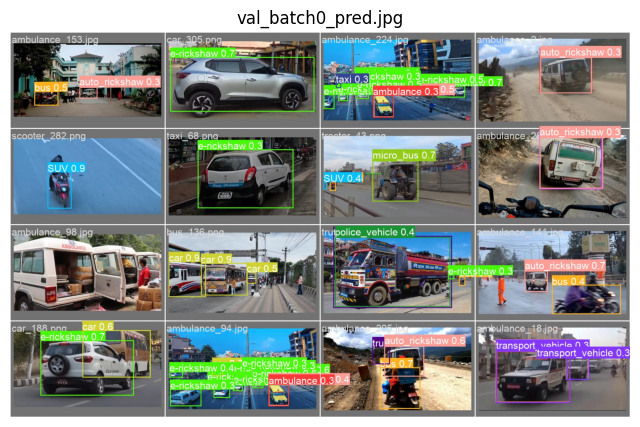

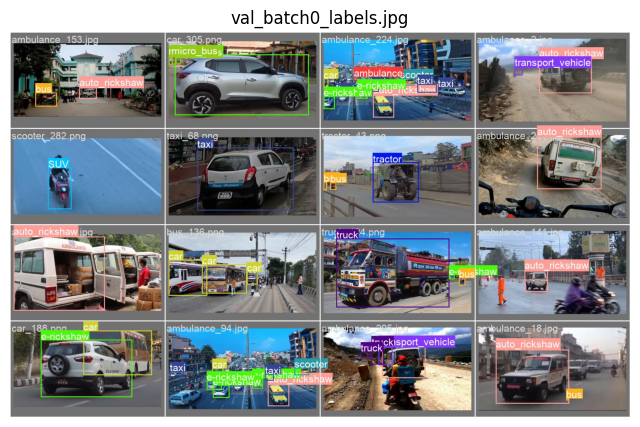

In [5]:
import subprocess
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt

# 定义验证命令
output_folder = "exp"  # 指定输出文件夹为 exp
val_command = [
    "python", "val.py",
    "--data", "data/data.yaml",
    "--weights", "runs/train/exp/weights/best.pt",
    "--task", "test",
    "--name", output_folder  # 假设 val.py 支持 --name 参数来指定输出文件夹名称
]

output_dir = os.path.join("yolov5", "runs", "val", output_folder)

try:
    # 清理之前的输出文件夹内容，直接删除并重新创建文件夹
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)  # 删除整个文件夹及其内容

    # 执行验证命令，并指定编码和错误处理策略
    result = subprocess.run(
        val_command,
        cwd="yolov5",
        check=True,
        capture_output=True,
        text=True,                 # 使用文本模式
        encoding='utf-8',          # 明确指定编码为 utf-8
        errors='replace'           # 无法解码的字符将被替换
    )

    # 输出最终结果
    print("Model evaluation completed.")
    print("Final Results:")
    print(result.stdout)

    images_to_show = [
        "confusion_matrix.png",
        "P_curve.png",
        "R_curve.png",
        "PR_curve.png",
        "val_batch0_pred.jpg",
        "val_batch0_labels.jpg"
    ]

    for img_name in images_to_show:
        img_path = os.path.join(output_dir, img_name)
        if os.path.exists(img_path):
            img = Image.open(img_path)

            # 创建新的图表窗口并显示图像
            plt.figure(figsize=(8, 8))
            plt.imshow(img)
            plt.title(img_name)
            plt.axis('off')  # 关闭坐标轴
            plt.show()

        else:
            print(f"Image {img_name} not found.")

except subprocess.CalledProcessError as e:
    print(f"Model evaluation failed with return code {e.returncode}")
    print(f"Command output: {e.output}")  # 打印完整的命令输出
    print(f"Error output: {e.stderr}")

except Exception as e:
    print(f"An error occurred: {e}")